In [1]:
from skimage.transform import PiecewiseAffineTransform, warp
from skimage import data
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def grid_pnt_str_to_list( grid_pnt_str ):
    return grid_pnt_str.replace('(','').replace(')','').replace(' ','').split(',')

def get_2d_grid_dict( grid_dict, z_plane ):
    grid_dict_2D = {}
    
    for grid1_pnt_str in grid_dict.keys():
        # Convert the string-key into coordinate pair
        grid1_pnt_coors = grid_pnt_str_to_list( grid1_pnt_str )
        # Ignore if not on proper z plane
        if int(grid1_pnt_coors[2])!=z_plane:
            continue
        grid1_pnt_coors_2D = [int(grid1_pnt_coors[0]), \
                                int(grid1_pnt_coors[1])]
        
        # Add the grid point coordinates to the list of original grid point coordinates
        grid2_pnt_coors = grid_dict[grid1_pnt_str]
        grid2_pnt_coors_2D = [int(grid2_pnt_coors[0]), \
                                int(grid2_pnt_coors[1])]
        
        grid_dict_2D[str(tuple(grid1_pnt_coors_2D))] = tuple(grid2_pnt_coors_2D)
    return grid_dict_2D

def get_grid_lists_from_dict( grid_dict ):
    grid1_all_coordinates = []
    grid2_all_coordinates = []
    
    for grid1_pnt_str in grid_dict.keys():
        grid1_coors = []
        # Convert the string-key into coordinate pair
        grid1_pnt_coors = grid_pnt_str_to_list( grid1_pnt_str )
        # Add coordinates into list of float coordinates
        for grid1_pnt_coor in grid1_pnt_coors:
            grid1_coors.append(float(grid1_pnt_coor))
            
        grid1_all_coordinates.append( grid1_coors )
        grid2_all_coordinates.append( list(grid_dict[grid1_pnt_str]) )
    return np.array(grid1_all_coordinates), np.array(grid2_all_coordinates)

def my_round( x, base=5 ):
    return int( base * round(float(x)/base))

def get_full_volume_without_offset( volume, offset ):
    volume_shape = np.shape( volume )
    offset_shape = np.shape( offset )
    assert len(volume_shape)==offset_shape[0]
    
    volume_noOffset = np.zeros( (volume_shape[0]+offset[0],
                                 volume_shape[1]+offset[1],
                                 volume_shape[2]+offset[2]) )
    volume_noOffset[-volume_shape[0]:,-volume_shape[1]:,-volume_shape[2]:] = volume.copy()
    return volume_noOffset

In [59]:
import time

import neuroglancer
import numpy as np
            
class GridLayer():
    def __init__(self, viewer, shape=(800, 600, 500),  vox_size=(10000, 10000, 10000)):
        self.vox_size = vox_size
        self.shape = shape
        self.jump_x = 150
        self.jump_y = 150
        self.jump_z = 20
        self.viewer = viewer
        self.grid_dict = {}
        self.grid_dict_abs = {}
        self.triangle_index_to_grid_pts = {}

    def get_grid_layer(self):
        grid_layer = neuroglancer.AnnotationLayer(voxel_size=self.vox_size)
        # grid_array = np.empty(self.shape, dtype=object)

        point_list = []

        for i in range(0, self.shape[0], self.jump_x):
            for j in range(0, self.shape[1], self.jump_y):
                for k in range(0, self.shape[2], self.jump_z):
                    self.grid_dict[repr((i, j, k))] = (i, j, k)
                    point_list.append((i, j, k))

        grid_layer.annotations = [neuroglancer.PointAnnotation(id=repr(pos), point=pos) for pos in point_list]

        return grid_layer
    
    def update_grid_dict(self):
        """
        Loads the current locations of every gridpoint and saves in the grid_dict format
        """
        with self.viewer.txn() as s:
            ss = s.layers['points']
            grid_as_json = ss.to_json()
            grid_list = grid_as_json['annotations']

        for gridpnt in grid_list:
            original_pos = gridpnt['id']
            curr_pos = gridpnt['point']
            integer_coordinates = map(int, curr_pos)
            integer_coordinates[2] = my_round( integer_coordinates[2], self.jump_z)
            self.grid_dict[original_pos] = tuple(integer_coordinates)
            
            # Currently unused, may be used later
            # Update grid_dict_abs
#             abs_grid1_pos_tuple = list(original_pos.replace('(','').replace(')','').replace(' ','').split(','))
#             abs_grid1_pos_tuple = map(float, abs_grid1_pos_tuple)
            
#             abs_grid1_pos_tuple[0] = int(abs_grid1_pos_tuple[0]*self.jump_x)
#             abs_grid1_pos_tuple[1] = int(abs_grid1_pos_tuple[1]*self.jump_y)
#             abs_grid1_pos_tuple[2] = int(abs_grid1_pos_tuple[2]*self.jump_z)
            
#             float_grid2_coordinates = map(float, curr_pos)
#             abs_grid2_pos_tuple = ( int(float_grid2_coordinates[0]*self.jump_x),
#                                     int(float_grid2_coordinates[1]*self.jump_y),
#                                     int(float_grid2_coordinates[2]*self.jump_z))
#             self.grid_dict_abs[str(tuple(abs_grid1_pos_tuple))] = abs_grid2_pos_tuple

    def print_coordiante(self):
        if 'selectedAnnotation' in self.viewer.state.layers._layers[2]._json_data:
            print(self.grid_dict[self.viewer.state.layers._layers[2]._json_data['selectedAnnotation']])
            
    
    
class InteractiveInference(object):
    def __init__(self, cube):

        viewer = self.viewer = neuroglancer.Viewer()
        viewer.actions.add('move_left', self.move_cube_left)
        viewer.actions.add('move_down', self.move_cube_down)
        viewer.actions.add('move_right', self.move_cube_right)
        viewer.actions.add('move_up', self.move_cube_up)
        viewer.actions.add('morph_volume', self.morph_volume_layer)
        viewer.actions.add('reset_cube', self.reset_cube_volume)
        viewer.actions.add('reset_grid', self.reset_grid_points)
        
#         self.cube_voxel_size = [10000, 10000, 10000]
        self.cube_voxel_size = [5000, 5000, 20000]

        self.cube = cube
        self.off_x = 1
        self.off_y = 1
        self.off_z = 0
        self.grid_layer = GridLayer(self.viewer)
        self.cube_volm = neuroglancer.LocalVolume(data=self.cube, voxel_size=self.cube_voxel_size, voxel_offset=[self.off_x, self.off_y, self.off_z])

        with viewer.config_state.txn() as s:
            s.input_event_bindings.data_view['shift+keyw'] = 'move_up'
            s.input_event_bindings.data_view['shift+keys'] = 'move_down'
            s.input_event_bindings.data_view['shift+keya'] = 'move_left'
            s.input_event_bindings.data_view['shift+keyd'] = 'move_right'
            s.input_event_bindings.data_view['shift+keym'] = 'morph_volume'
            s.input_event_bindings.data_view['shift+keyc'] = 'reset_cube'
            s.input_event_bindings.data_view['shift+keyg'] = 'reset_grid'

        with viewer.txn() as s:
            s.layers['image'] = neuroglancer.ImageLayer(
                source='precomputed://https://mousebrainatlas-datajoint-jp2k.s3.amazonaws.com/precomputed/MD585_fullres')
            # Resets X/Y/Z plane orientation
            s.navigation.pose.orientation = [0,0,0,1]
            # Zooms out 
        #     s.navigation.zoomFactor = 10000 # If 4panel
            s.navigation.zoomFactor = 4000 # If xy

            # Resets 3D Viewer Orientation
            s.perspectiveOrientation = [0,0,0,1]
            # Zooms out
            s.perspectiveZoom = 75000
            
            s.layers['cube'] = neuroglancer.ImageLayer(source=self.cube_volm)
            s.layers['points'] = self.grid_layer.get_grid_layer()
            # s.layers['points'] = neuroglancer.AnnotationLayer(voxel_size=[100000, 100000, 100000])\
            
    def reset_grid_points(self, action_state):
        with viewer.txn() as s:
            s.layers['points'] = self.grid_layer.get_grid_layer()
    
    def reset_cube_volume(self, action_state):
        self.off_x = 1
        self.off_y = 1
        self.off_z = 0
        self.cube = get_cube_test_volume()
        self.cube_volm = neuroglancer.LocalVolume(data=self.cube, 
                                                  voxel_size=self.cube_voxel_size, 
                                                  voxel_offset=[self.off_x, self.off_y, self.off_z])
        with viewer.txn() as s:
            s.layers['cube'] = neuroglancer.ImageLayer(source=self.cube_volm)

    def move_cube_left(self, action_state):

        self.off_x -= 10
        cube_volm = neuroglancer.LocalVolume(data=self.cube, voxel_size=self.cube_voxel_size,
                                             voxel_offset=[self.off_x, self.off_y, self.off_z])
        cube_layer = neuroglancer.SegmentationLayer(source=cube_volm)
        with self.viewer.txn() as s:
            s.layers['cube'] = cube_layer

    def move_cube_right(self, action_state):
        self.off_x += 10
        cube_volm = neuroglancer.LocalVolume(data=self.cube, voxel_size=self.cube_voxel_size,
                                             voxel_offset=[self.off_x, self.off_y, self.off_z])
        cube_layer = neuroglancer.SegmentationLayer(source=cube_volm)
        with self.viewer.txn() as s:
            s.layers['cube'] = cube_layer

    def move_cube_up(self, action_state):
        self.off_y -= 10
        cube_volm = neuroglancer.LocalVolume(data=self.cube, voxel_size=self.cube_voxel_size,
                                             voxel_offset=[self.off_x, self.off_y, self.off_z])
        cube_layer = neuroglancer.SegmentationLayer(source=cube_volm)
        with self.viewer.txn() as s:
            s.layers['cube'] = cube_layer

    def move_cube_down(self, action_state):
        self.off_y += 10
        cube_volm = neuroglancer.LocalVolume(data=self.cube, voxel_size=self.cube_voxel_size,
                                             voxel_offset=[self.off_x, self.off_y, self.off_z])
        cube_layer = neuroglancer.SegmentationLayer(source=cube_volm)
        with self.viewer.txn() as s:
            s.layers['cube'] = cube_layer
            
    def morph_volume_layer(self, action_state):
        self.grid_layer.update_grid_dict()
        grid_map = self.grid_layer.grid_dict # Gets grid_dict
        grid_map_abs = self.grid_layer.grid_dict_abs
    
        cube_offsets = [self.off_x, self.off_y, self.off_z]
        self.cube = update_volume( grid_map, self.cube.copy(), cube_offsets )
        cube_volm = neuroglancer.LocalVolume(data=self.cube, voxel_size=self.cube_voxel_size,
                                             voxel_offset=[0, 0, 0])
        cube_layer = neuroglancer.SegmentationLayer(source=cube_volm)
        with self.viewer.txn() as s:
            s.layers['cube'] = cube_layer


def update_volume( grid_map, volume, volume_offset, noOffsets=False ):
    """
    This function will set the offset to zero
    """
    volume_offset = [volume_offset[2],volume_offset[1],volume_offset[0]]
    volume_shape = np.shape( volume )
    # "new_volume" created as a large volume with no offset
    new_volume = np.zeros( (volume_shape[0]+volume_offset[0],
                            volume_shape[1]+volume_offset[1]+200,
                            volume_shape[2]+volume_offset[2]+200), dtype=np.uint8 )
    # volume added into "new_volume" 
    volume_noOffset = get_full_volume_without_offset( volume, volume_offset )
    
    del volume
    
    new_max_x = 0
    new_max_y = 0
    
    for z_vol_level in range(volume_shape[2]):
        try:
            z = z_vol_level+volume_offset[0]
            
            grid_map_z = my_round( z_vol_level, 20) # HARDCODED 20 SHOULD BE SELF.JUMPZ
#             grid_dict_2D = get_2d_grid_dict( grid_map, 0 )
            grid_dict_2D = get_2d_grid_dict( grid_map, grid_map_z )
            grid_dict_2D_grid2, grid_dict_2D_grid1 = get_grid_lists_from_dict( grid_dict_2D )

            tform = PiecewiseAffineTransform()
            tform.estimate( grid_dict_2D_grid1 , grid_dict_2D_grid2 )

            image = volume_noOffset[z,:,:]
            rows, cols = image.shape[0], image.shape[1]
            out_rows, out_cols = rows+200, cols+200
            warped_img = warp(image, tform, output_shape=(out_rows, out_cols))
                        
            warped_img_max_nonzero_y = np.amax( np.nonzero(warped_img[:,:])[0] )
            warped_img_max_nonzero_x = np.amax( np.nonzero(warped_img[:,:])[1] )
            new_max_x = max( new_max_x, warped_img_max_nonzero_x)
            new_max_y = max( new_max_y, warped_img_max_nonzero_y)
            
            import cv2
            ret, warped_img = cv2.threshold(warped_img,.0001,1,cv2.THRESH_BINARY)
            
            new_volume[z,:,:] = warped_img
        except IndexError:
            pass
        except ValueError:
            pass
        
    cropped_new_volume = np.zeros( (volume_shape[0], new_max_y, new_max_x ), dtype=np.uint8 )
    cropped_new_volume[ :, -new_max_y:, -new_max_x:] = new_volume[ :, :new_max_y, :new_max_x]
        
    return cropped_new_volume

In [64]:
def get_cube_test_volume_real(cube_len=100):
    cube = np.zeros((cube_len, cube_len, cube_len), dtype=np.uint8)

    cube[:, :, :10] = 1
    cube[:, :, cube_len-10:cube_len] = 1

    cube[:10, :, :] = 1
    cube[cube_len-10:cube_len, :, :] = 1

    cube[:, :10, :] = 1
    cube[:, cube_len-10:cube_len, :] = 1
    
    return cube

def get_rect_test_volume(cube_len=100):
    cube = np.zeros((cube_len, cube_len, cube_len), dtype=np.uint8)

    cube[:, :, :10] = 1
    cube[:, :, cube_len-10:cube_len] = 1

    cube[:10, :, :] = 1
    cube[cube_len-10:cube_len, :, :] = 1

    cube[:, :10, :] = 1
    cube[:, cube_len-10:cube_len, :] = 1
    
    rectangle = np.zeros( (cube_len, 2*cube_len, cube_len), dtype=np.uint8 )
    rectangle[ 0:cube_len, 0:cube_len, 0:cube_len] = cube
    rectangle[ 0:cube_len, cube_len:2*cube_len, 0:cube_len] = cube
    
    return rectangle

def get_cube_test_volume():
    atlas_volume_fp = '/media/alexn/Data_2/Neuroglancer_Files/\
Neuroglancer_Volumes/Matrix/MD585/human_annotation/combined_volume/brainstem_xy5um_z20um/color_1_thickness_1_offset_0/volume_colored.npy'
    atlas_volume_fp = '/home/alexn/Desktop/MD585_IC_vol.np.npy'
#     vol = np.zeros( (279,1508,1508) )[0:279,0:1105,:] + np.load(atlas_volume_fp)
    vol = np.load(atlas_volume_fp)
    return vol

cube = get_cube_test_volume()

neuroglancer.set_server_bind_address(bind_address='0.0.0.0', bind_port=35000)

inf = InteractiveInference(cube)
viewer = inf.viewer
ip_name = 'ec2-52-53-248-156.us-west-1.compute.amazonaws.com'  ## Change for different machine
ip_name = '132.239.73.85'  ## Change for different machine

print('http://' + ip_name + ':' + viewer.get_viewer_url().split(':')[2])

http://132.239.73.85:35000/v/ab092931769a0bae0dab84621ed0ae00180b4b50/


In [62]:
! ls /home/alexn/Desktop/

Atlas_Meeting_Talking_Points  Goodwin-2019.pdf		References
atlas_patch_files	      MD585_IC_vol.np.npy	Restart
czi_to_tif		      Neuroglancer Suggestions
DK8_thumbnails		      old


In [27]:
np.shape(get_cube_test_volume())

(279, 1105, 1508)

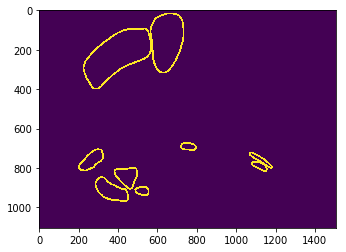

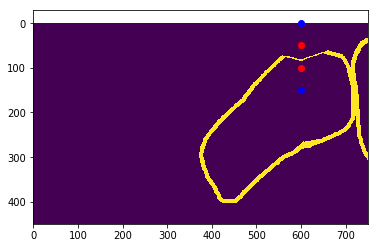

In [54]:
def update_volume( grid_map, volume, volume_offset, noOffsets=False ):
    """
    This function will set the offset to zero
    """
    volume_offset = [volume_offset[2],volume_offset[1],volume_offset[0]]
    volume_shape = np.shape( volume )
    # "new_volume" created as a large volume with no offset
    new_volume = np.zeros( (volume_shape[0]+volume_offset[0],
                            volume_shape[1]+volume_offset[1]+200,
                            volume_shape[2]+volume_offset[2]+200), dtype=np.uint8 )
    # volume added into "new_volume" 
    volume_noOffset = get_full_volume_without_offset( volume, volume_offset )
    
    del volume
    
    new_max_x = 0
    new_max_y = 0
    
    for z_vol_level in range(volume_shape[2]):
        try:
            z = z_vol_level+volume_offset[0]
            grid_dict_2D = get_2d_grid_dict( grid_map, 0 )
            grid_dict_2D_grid2, grid_dict_2D_grid1 = get_grid_lists_from_dict( grid_dict_2D )

            tform = PiecewiseAffineTransform()
            tform.estimate( grid_dict_2D_grid1 , grid_dict_2D_grid2 )

            image = volume_noOffset[z,:,:]
            rows, cols = image.shape[0], image.shape[1]
            out_rows, out_cols = rows+200, cols+200
            warped_img = warp(image, tform, output_shape=(out_rows, out_cols))
                        
                
            warped_img_max_nonzero_y = np.amax( np.nonzero(warped_img[:,:])[0] )
            warped_img_max_nonzero_x = np.amax( np.nonzero(warped_img[:,:])[1] )
            new_max_x = max( new_max_x, warped_img_max_nonzero_x)
            new_max_y = max( new_max_y, warped_img_max_nonzero_y)
            
            import cv2
            ret, warped_img = cv2.threshold(warped_img,.0001,1,cv2.THRESH_BINARY)
            
            new_volume[z,:,:] = warped_img
        except IndexError:
            pass
        except ValueError:
            pass
        
    cropped_new_volume = np.zeros( (volume_shape[0], new_max_y, new_max_x ), dtype=np.uint8 )
    cropped_new_volume[ :, -new_max_y:, -new_max_x:] = new_volume[ :, :new_max_y, :new_max_x]
        
    return cropped_new_volume

# TESTING

gd = inf.grid_layer.grid_dict

# gd['(0, 0, 0)'] = (0,0,0)
gd['(0, 0, 0)'] = (0,0,0)
# gd['(150, 0, 0)'] = (150,0,0)
# gd['(150, 0, 0)'] = (150,50,0)
# gd['(150, 150, 0)'] = (150,100,0)

gd['(600, 0, 0)'] = (600,50,0)
gd['(600, 150, 0)'] = (600,100,0)

cube = get_cube_test_volume( )

new_cube = update_volume( gd, cube.copy(), [150,1,0] )

plt.imshow(cube[100,:,:], norm=matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False))
plt.show()
plt.imshow(new_cube[100,:,:], norm=matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False))

plt.scatter( [600,600], [0,150], c='b' )
plt.scatter( [600,600], [50,100], c='r' )

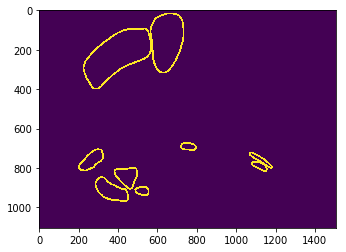

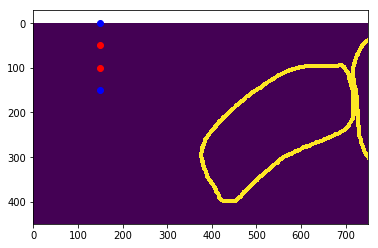

In [53]:
plt.imshow(cube[100,:,:], norm=matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False))
plt.show()
plt.imshow(new_cube[100,:,:], norm=matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False))

plt.scatter( [150,150], [0,150], c='b' )
plt.scatter( [150,150], [50,100], c='r' )

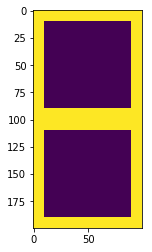

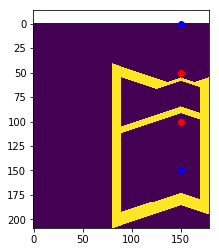

In [46]:

# TESTING

gd = inf.grid_layer.grid_dict

# gd['(0, 0, 0)'] = (0,0,0)
gd['(0, 0, 0)'] = (0,0,0)
# gd['(150, 0, 0)'] = (150,0,0)
gd['(150, 0, 0)'] = (150,50,0)
gd['(150, 150, 0)'] = (150,100,0)

rect = get_rect_test_volume()

new_rect = update_volume( gd, rect.copy(), [80,15,0] )

plt.imshow(rect[10,:,:], norm=matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False))
plt.show()
plt.imshow(new_rect[10,:,:], norm=matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False))

plt.scatter( [150,150], [0,150], c='b' )
plt.scatter( [150,150], [50,100], c='r' )

In [37]:
np.shape( update_volume( gd, rect.copy(), [1,1,0] ) )

(100, 200, 100)

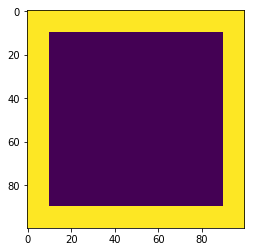

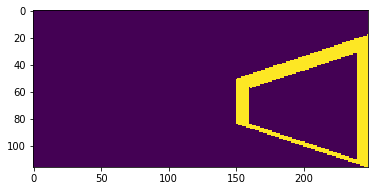

In [186]:
plt.imshow(cube[10,:,:], norm=matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False))
plt.show()
plt.imshow(new_cube[10,:,:], norm=matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False))

ValueError: too many values to unpack

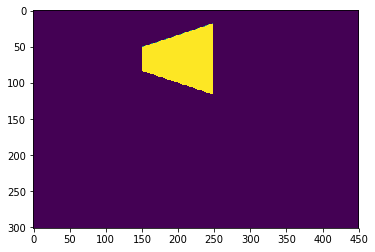

In [196]:
# TESTING

gd = inf.grid_layer.grid_dict

# gd['(0, 0, 0)'] = (0,0,0)
gd['(0, 0, 0)'] = (0,0,0)
# gd['(150, 0, 0)'] = (150,0,0)
gd['(150, 0, 0)'] = (150,50,0)
gd['(150, 150, 0)'] = (150,100,0)

cube = get_cube_test_volume( 100 )

new_cube, new_offset = update_volume( gd, cube.copy(), [150,1,0] )